In [3]:
import torch
import torch_geometric

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

datasets = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [17]:
print(f"Number of graphs: {len(datasets)}")
print(f"Number of features: {datasets.num_features}")
print(f"Number of classes: {datasets.num_classes}")

data = datasets[0]

print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes : .2f}")
print(f"Is undirected: {data.is_undirected()}")

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of training nodes: 140
Training node label rate:  0.05
Is undirected: True


In [20]:
print(data.x.shape) # Number of Nodes, Number of Features

data.x[0][:150] # Print normalized word counts of the first datapoint

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [22]:
data.y # Labels 

tensor([3, 4, 4,  ..., 3, 3, 3])

In [25]:
print(len(data.test_mask) == data.num_nodes)
print(data.test_mask)

True
tensor([False, False, False,  ...,  True,  True,  True])


In [28]:
data.edge_index.t()

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [29]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #GATConv Model

In [32]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels): # hidden_channels = embedding size (larger the more the model coulc capture more information )
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # initialize the layers
        self.conv1 = GCNConv(datasets.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, datasets.num_classes)
    
    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.5, training=self.training)

        # Output Layer
        x = F.softmax(self.out(x), dim=1)
        return x 
model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 64)
  (out): Linear(in_features=64, out_features=7, bias=True)
)


# Graph NN for Node Classifiaction

In [35]:
# initialize the optimizer (hyperparameters)

learning_rate = 0.01
learning_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_decay)

In [36]:
# Define loss function (Cross Entropy for Classification problems 
# with probability distributions)
criterion = torch.nn.CrossEntropyLoss()

In [53]:
def train():
    model.train()
    optimizer.zero_grad()
    # Use all data as input, because all nodes have node features
    out = model(data.x, data.edge_index)
    # Only use nodes with label available for loss calculation --> mask only train data
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    # Backward prop
    loss.backward()
    optimizer.step()
    return loss 


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # Use the class with highest probability
    pred = out.argmax(dim=1)
    # Check against the true labels
    test_correct = pred[data.test_mask] == data.y[data.test_mask]

    test_acc = int(test_correct.sum().item()) / int(data.test_mask.sum().item())

    return test_acc



In [50]:
# Training 
losses = []
for epoch in range(0, 5001):
    loss = train()
    losses.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss.item():.4f}")


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

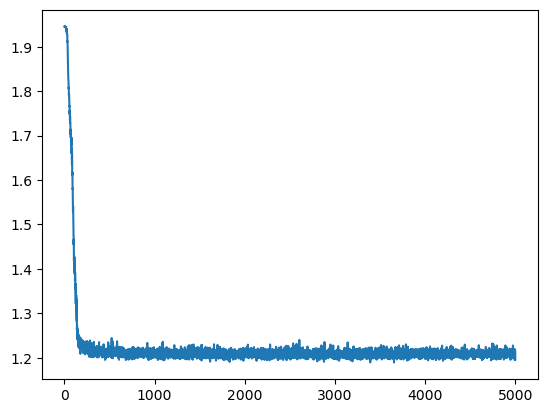

In [44]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i, l in enumerate(losses_float)]
plt = sns.lineplot(x = loss_indices, y = losses_float)
plt

In [56]:
test_acc = test()
print(f"Test Accuracy: {test_acc*100:.4f}%")

Test Accuracy: 77.5000%
